# Semantic Sentiment Analysis
The purpose of this notebook is to explore the effectiveness of an LLM sentiment analysis solution compared to a classical approach. The main problem both approaches will try to solve is classifying text as either positive or negative. Both the solution explored will use semantic analysis techniques to classify the text with more focus on the meaning of behind the text as opposed to word frequencies.

In [10]:
from datasets import load_dataset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from bertviz import model_view, head_view
from transformers import AutoTokenizer, AutoModel, utils


In [2]:
ds = load_dataset("yassiracharki/Amazon_Reviews_Binary_for_Sentiment_Analysis")
df_train = ds['train'].to_pandas()
df_test = ds['test'].to_pandas()

Here's a snapshot of the dataset. The class_index is the target variable. It contains the values 1 for a negative review and 2 for a positive review. 
There are two potential methods for classifiying the review; either classify the review title or the review content. Using the review title would be quicker for models since they usually contain less text than the review text however the text should contain a clearer sentiment than the title. This can be seen in the title 'Remember, Pull your Jaw off the Floor After Hearing it'. The reviewer may be implying that product was shockingly bad or extremely good; it's not immediately clear from just the title what they are implying and more context from the review content is needed.

In [3]:
df_train.head()


,class_index,review_title,review_text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


Let's take 700 reviews for the train set and 300 for the test set. 

In [5]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')  # Using bigrams for context
X_raw = df_train.head(n=1000)['review_text']
X = tfidf.fit_transform(X_raw)
y = df_train.head(n=1000)['class_index']
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)

## EDA
We will look at some of the features in the text.

We can see that there are more negative reviews than positive reviews however the class imbalance is low so we won't need to apply any class balancing techniques.

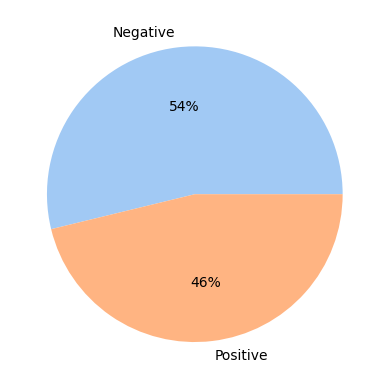

In [23]:
# Get sentiment counts
sentiment_counts = list(df_train.head(n=1000)['class_index'].value_counts())
labels= ['Negative', 'Positive']
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(sentiment_counts, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

The graph below shows that most of the review titles are less than 30 characters long.

In [35]:
longest_review_title_length =np.max(df_train.head(1000)['review_title'].str.len())
print(f"The longest review title is {longest_review_title_length} characters long.")

The longest review title is 127 characters long.


<Axes: >

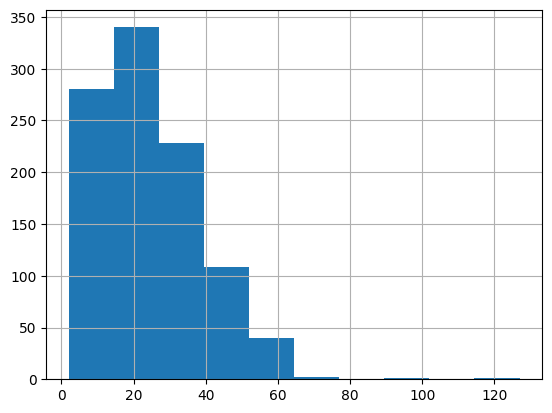

In [26]:
df_train.head(1000)['review_title'].str.len().hist()

The graph below shows that most reviews have less than 500 characters.  

In [39]:
longest_review_length = np.max(df_train.head(1000)['review_text'].str.len())
print(f"The longest review has {longest_review_length} characters.")

The longest review has 1001 characters.


<Axes: >

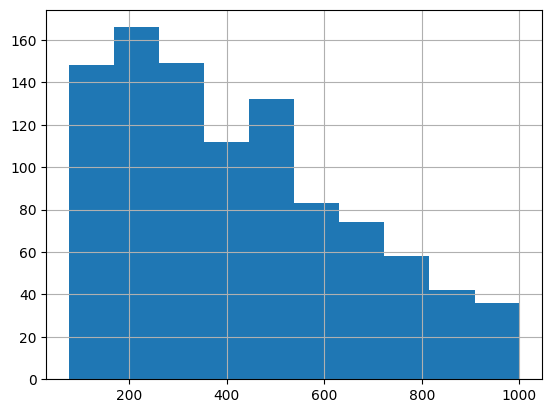

In [36]:
df_train.head(1000)['review_text'].str.len().hist()

The list below shows the most frequently occurring words after removing the stop words. Words like 'wrong', 'wow' and 'worthless' appear more than 1000 times altogether which implies it might be possible to perform the sentiment analysis on the title. 

In [46]:
from sklearn.feature_extraction import text

vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words=list(text.ENGLISH_STOP_WORDS))

vectorizer.fit_transform(df_train.head(700)['review_title'])

idf_values = dict(zip(vectorizer.get_feature_names_out(), vectorizer.idf_))


# printing the vocabulary sorted
print({k: v for k, v in sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True)})

{'zoo': 1038, 'zero': 1037, 'zen': 1036, 'yout': 1035, 'yes': 1034, 'year': 1033, 'ya': 1032, 'wrong': 1031, 'written': 1030, 'writing': 1029, 'writer': 1028, 'wow': 1027, 'worthless': 1026, 'worth': 1025, 'worst': 1024, 'worn': 1023, 'worlds': 1022, 'world': 1021, 'works': 1020, 'worked': 1019, 'work': 1018, 'wonderfully': 1017, 'wonderful': 1016, 'wondeful': 1015, 'won': 1014, 'woburn': 1013, 'witness': 1012, 'wish': 1011, 'winning': 1010, 'winner': 1009, 'wildly': 1008, 'wild': 1007, 'wicked': 1006, 'white': 1005, 'whispers': 1004, 'weeks': 1003, 'web': 1002, 'wearing': 1001, 'wear': 1000, 'way': 999, 'waxed': 998, 'wave': 997, 'waterproof': 996, 'watch': 995, 'wasted': 994, 'waste': 993, 'wasnt': 992, 'wasn': 991, 'warranty': 990, 'warning': 989, 'warm': 988, 'wanted': 987, 'want': 986, 'wait': 985, 'waist': 984, 'wack': 983, 'voices': 982, 'voice': 981, 'vintage': 980, 'views': 979, 'video': 978, 've': 977, 'vampires': 976, 'vampire': 975, 'value': 974, 'usual': 973, 'using': 972,

In [49]:
corpus=[]
review_words= df_train.head(700)['review_title'].str.split().values.tolist()
corpus=[word for i in review_words for word in i]
dic=defaultdict(int)
for word in corpus:
    if word in text.ENGLISH_STOP_WORDS:
        dic[word]+=1
print({k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)})

{'the': 57, 'a': 47, 'and': 46, 'of': 44, 'for': 37, 'to': 30, 'it': 25, 'is': 24, 'in': 21, 'not': 20, 'this': 18, 'on': 18, 'but': 15, 'with': 12, 'you': 11, 'as': 10, 'one': 10, 'what': 10, 'so': 10, 'that': 10, 'ever': 9, 'your': 9, 'my': 9, 'than': 9, 'i': 8, 'at': 8, 'from': 8, 'very': 8, 'was': 8, 'have': 7, 'be': 6, 'or': 5, 'by': 5, 'no': 5, 'out': 5, 'some': 5, 'an': 4, 'more': 4, 'then': 4, 'too': 4, 'after': 4, 'me': 4, 'has': 3, 'do': 3, 'its': 3, 'will': 3, 'another': 3, 'her': 3, 'give': 3, 'even': 2, 'into': 2, 'should': 2, 'how': 2, 'up': 2, 'am': 2, 'where': 2, 'get': 2, 'found': 2, 'his': 2, 'must': 2, 'because': 2, 'well': 2, 'less': 2, 'same': 2, 'over': 2, 'name': 2, 'much': 2, 'put': 2, 'please': 1, 'beyond': 1, 'us': 1, 'are': 1, 'would': 1, 'here': 1, 'already': 1, 'least': 1, 'across': 1, 'whole': 1, 'own': 1, 'once': 1, 'three': 1, 'four': 1, 'been': 1, 'keep': 1, 'off': 1, 'again': 1, 'these': 1, 'find': 1, 'most': 1, 'many': 1, 'full': 1, 'those': 1, 'done'

In [53]:
def increment_word(word, reference):
    reference[word] += 1
    return reference

corpus=[]
review_words= df_train.head(700)['review_title'].str.split().values.tolist()
word_counts =defaultdict(int)
corpus=[increment_word(word, word_counts) for i in review_words for word in i if word in text.ENGLISH_STOP_WORDS]
corpus[-1]
print({k: v for k, v in sorted(corpus[-1].items(), key=lambda item: item[1], reverse=True)})

{'the': 57, 'a': 47, 'and': 46, 'of': 44, 'for': 37, 'to': 30, 'it': 25, 'is': 24, 'in': 21, 'not': 20, 'this': 18, 'on': 18, 'but': 15, 'with': 12, 'you': 11, 'as': 10, 'one': 10, 'what': 10, 'so': 10, 'that': 10, 'ever': 9, 'your': 9, 'my': 9, 'than': 9, 'i': 8, 'at': 8, 'from': 8, 'very': 8, 'was': 8, 'have': 7, 'be': 6, 'or': 5, 'by': 5, 'no': 5, 'out': 5, 'some': 5, 'an': 4, 'more': 4, 'then': 4, 'too': 4, 'after': 4, 'me': 4, 'has': 3, 'do': 3, 'its': 3, 'will': 3, 'another': 3, 'her': 3, 'give': 3, 'even': 2, 'into': 2, 'should': 2, 'how': 2, 'up': 2, 'am': 2, 'where': 2, 'get': 2, 'found': 2, 'his': 2, 'must': 2, 'because': 2, 'well': 2, 'less': 2, 'same': 2, 'over': 2, 'name': 2, 'much': 2, 'put': 2, 'please': 1, 'beyond': 1, 'us': 1, 'are': 1, 'would': 1, 'here': 1, 'already': 1, 'least': 1, 'across': 1, 'whole': 1, 'own': 1, 'once': 1, 'three': 1, 'four': 1, 'been': 1, 'keep': 1, 'off': 1, 'again': 1, 'these': 1, 'find': 1, 'most': 1, 'many': 1, 'full': 1, 'those': 1, 'done'

In [55]:
print({k: v for k, v in sorted(corpus[1].items(), key=lambda item: item[1], reverse=True)})

{'the': 57, 'a': 47, 'and': 46, 'of': 44, 'for': 37, 'to': 30, 'it': 25, 'is': 24, 'in': 21, 'not': 20, 'this': 18, 'on': 18, 'but': 15, 'with': 12, 'you': 11, 'as': 10, 'one': 10, 'what': 10, 'so': 10, 'that': 10, 'ever': 9, 'your': 9, 'my': 9, 'than': 9, 'i': 8, 'at': 8, 'from': 8, 'very': 8, 'was': 8, 'have': 7, 'be': 6, 'or': 5, 'by': 5, 'no': 5, 'out': 5, 'some': 5, 'an': 4, 'more': 4, 'then': 4, 'too': 4, 'after': 4, 'me': 4, 'has': 3, 'do': 3, 'its': 3, 'will': 3, 'another': 3, 'her': 3, 'give': 3, 'even': 2, 'into': 2, 'should': 2, 'how': 2, 'up': 2, 'am': 2, 'where': 2, 'get': 2, 'found': 2, 'his': 2, 'must': 2, 'because': 2, 'well': 2, 'less': 2, 'same': 2, 'over': 2, 'name': 2, 'much': 2, 'put': 2, 'please': 1, 'beyond': 1, 'us': 1, 'are': 1, 'would': 1, 'here': 1, 'already': 1, 'least': 1, 'across': 1, 'whole': 1, 'own': 1, 'once': 1, 'three': 1, 'four': 1, 'been': 1, 'keep': 1, 'off': 1, 'again': 1, 'these': 1, 'find': 1, 'most': 1, 'many': 1, 'full': 1, 'those': 1, 'done'

## Classical Approach
We will use an SVM to classify the text. This fits a vector plane to separate the instances based on sentiment (positive or negative). 

In [6]:
# Train an SVM classifier
svm = SVC(kernel='linear', random_state=234)
svm.fit(X_train_t, y_train_t)

# Evaluate the model
y_pred = svm.predict(X_test_t)

# Print the classification report and accuracy
print("Accuracy:", accuracy_score(y_test_t, y_pred))
print("\nClassification Report:\n", classification_report(y_test_t, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_t, y_pred))

Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.88      0.81       158
           2       0.83      0.67      0.74       142

    accuracy                           0.78       300
   macro avg       0.79      0.77      0.78       300
weighted avg       0.79      0.78      0.78       300


Confusion Matrix:
 [[139  19]
 [ 47  95]]


In [13]:
y_pred

array([1, 1, 1])

### LLM approach
We try zero shot prompting with LLM. This one of the main advantages of the LLM; there is no need for training. It is possible to just use an off the shelf model to get great accuracy with little tuning. We use Facebook's BART Large MNLI model using the HuggingFace transformers package.

In [7]:
from transformers import pipeline
# distilbert/distilbert-base-uncased-finetuned-sst-2-english
# HooshvareLab/bert-fa-base-uncased-sentiment-deepsentipers-binary "sentiment-analysis",
# model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis" 
classifier = pipeline(model="facebook/bart-large-mnli")
llm_results = classifier(X_test.to_list(), truncation=True, max_length=512, candidate_labels=['negative', 'positive'])

2024-08-26 15:22:18.418767: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
# llm_results_bin = [x['label']=='positive' for x in llm_results]

In [8]:
llm_results_bin = [(x['labels'][0]=='positive')+1 for x in llm_results]
print("Accuracy:", accuracy_score(y_test, llm_results_bin))
print("\nClassification Report:\n", classification_report(y_test, llm_results_bin))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, llm_results_bin))

Accuracy: 0.9033333333333333

Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.92      0.91       158
           2       0.91      0.88      0.90       142

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300


Confusion Matrix:
 [[146  12]
 [ 17 125]]


#### Visualising Attention

In [11]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
model = AutoModel.from_pretrained("facebook/bart-large-mnli", output_attentions=True)
inputs = tokenizer.encode("Bob the builder drinks a glass of water.", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
head_view(attention, tokens)

BartModel is using BartSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


<IPython.core.display.Javascript object>